In [1]:
import urllib.request, json 

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data = json.loads(url.read().decode())

print(data[0])

{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


In [2]:
import csv
import numpy as np
import pandas as pd


# df = pd.DataFrame(data=data, columns=['date', 'weightedAverage', 'low', 'high', 'open', 'close', 'quoteVolume'])

# df = df.fillna(method='ffill')
# df.to_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index=False)

# Data already downloaded
df = pd.read_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index_col=None)

df.head()

,date,weightedAverage,low,high,open,close,quoteVolume
0,1483228800,964.642624,964.000000,965.000001,965.000001,964.000001,5.596723
1,1483229100,965.858035,964.000002,966.150000,966.150000,964.000002,0.087282
2,1483229400,963.946565,962.028165,966.149988,964.050000,964.000000,2.737368
3,1483229700,962.024978,961.700000,964.000000,962.028165,962.200001,3.550087
4,1483230000,963.568648,962.769304,964.677377,964.000011,962.849999,0.083323


In [3]:
# df = df[-60000:]
print(df.shape)

(187729, 7)


In [4]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler_window_size = 1000
scaled_data = np.ndarray(dataset.shape)

# Normalize data
scaler = MinMaxScaler().fit(np.array(dataset[0:scaler_window_size]))

for i in range(0, dataset.shape[0]//scaler_window_size):   
    scaled_data[i*scaler_window_size:(i+1)*scaler_window_size] = scaler.transform(np.array(dataset[i*scaler_window_size:(i+1)*scaler_window_size]))
    scaler = MinMaxScaler().fit(np.array(dataset[i*scaler_window_size:(i+1)*scaler_window_size]))
    
scaled_data[i*scaler_window_size:] = scaler.transform(np.array(dataset[i*scaler_window_size:]))

np.savetxt("scaled_data.csv", scaled_data, delimiter=";")

In [6]:
# Split the dataset into training (70%), cross validation (20%) and test (10%) set
samples_num = scaled_data.shape[0]

valid_split = 0.1
test_split = 0.01

train_full_window = int((samples_num//scaler_window_size) * (1-valid_split-test_split)) * scaler_window_size
valid_full_window = int((samples_num//scaler_window_size) * (valid_split)) * scaler_window_size

dataset_train = scaled_data[0:train_full_window]
dataset_valid = scaled_data[train_full_window:train_full_window+valid_full_window]
dataset_test = scaled_data[train_full_window+valid_full_window:]

In [7]:
print(dataset_train.shape)
print(dataset_valid.shape)
print(dataset_test.shape)

(166000, 6)
(18000, 6)
(3729, 6)


In [8]:
print(dataset_train[:5])

[[0.0498219  0.05769549 0.03858467 0.05534237 0.05037205 0.03290795]
 [0.05970707 0.0576955  0.04793444 0.06462746 0.05037206 0.00051321]
 [0.04416071 0.04139663 0.04793434 0.04767206 0.05037204 0.01609534]
 [0.02853208 0.03868408 0.03045442 0.03134778 0.0359852  0.02087402]
 [0.04108705 0.04752276 0.03596166 0.04726846 0.04118044 0.00048993]]


In [9]:
# Makes a training examples from year data with a timesteps window size

def makeXy(data, timesteps, scaler_window_size = 999999999):
    X = []
    y = []
    
    for i in range(timesteps, data.shape[0]):
        if((i-timesteps)//scaler_window_size == i//scaler_window_size):
            X.append(list(data[i-timesteps:i]))
            y.append(data[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [10]:
print(np.array(dataset_train).shape)

(166000, 6)


In [18]:
import numpy as np

timestep = 250 # Make decision from last 'timestep' candles

# Create training examples

train_X, train_y = makeXy(dataset_train, timestep, scaler_window_size)
valid_X, valid_y = makeXy(dataset_valid, timestep, scaler_window_size)
test_X, test_y = makeXy(dataset_test, timestep, scaler_window_size)
    
print(train_X.shape)
print(train_y.shape)

# train_X = train_X.reshape(train_X.shape[0],-1)
# valid_X = valid_X.reshape(valid_X.shape[0],-1)
# test_X = test_X.reshape(test_X.shape[0],-1)

# print(train_X.shape)
# print(train_y.shape)

(124500, 250, 6)
(124500, 6)


In [19]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.externals import joblib

# scaler_window_size = 5000
# X_train = np.ndarray(dataset_train.shape)

# # Normalize data
# for i in range(dataset_train.shape[0]//scaler_window_size):   
#     scaler = StandardScaler().fit(np.array(dataset_train[i*scaler_window_size:(i+1)*scaler_window_size]))
#     X_train[i*scaler_window_size:(i+1)*scaler_window_size] = scaler.transform(np.array(dataset_train[i*scaler_window_size:(i+1)*scaler_window_size]))
    
# X_train[i*scaler_window_size:] = scaler.transform(np.array(dataset_train[i*scaler_window_size:]))

# # scaler = StandardScaler().fit(np.array(dataset_train[110000:120000]))
# # X_train = scaler.transform(np.array(dataset_train))
# X_valid = scaler.transform(np.array(dataset_valid))
# X_test = scaler.transform(np.array(dataset_test))

# # Saving scaler for prediction
# scaler_filename = "scaler.save"
# joblib.dump(scaler, scaler_filename) 

# print ("X_train:\n" + str(X_train))
# print ("\nX_valid:\n" + str(X_valid))
# print ("\nX_test:\n" + str(X_test))

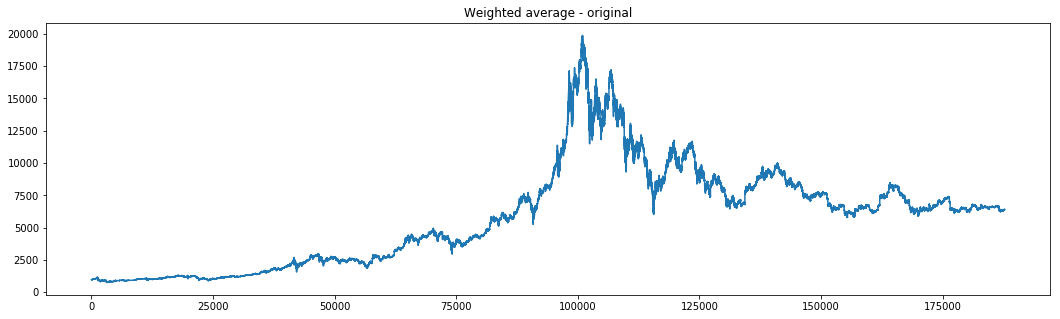

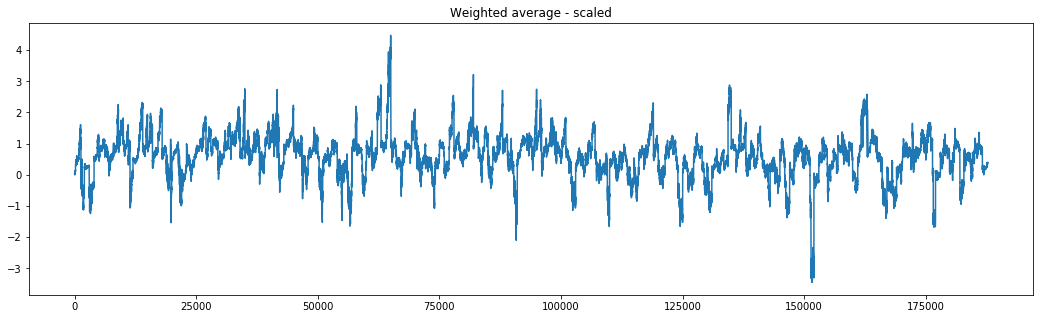

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Weighted average - original')
plt.plot(dataset[:,0])
plt.show()

plt.figure(figsize=(18, 5))
plt.title('Weighted average - scaled')
plt.plot(scaled_data[:,0])
plt.show()

In [ ]:
# print(train_X[0])
# print(train_y[0])

In [13]:
import tensorflow as tf
from keras import backend as K

num_cores = 6

num_CPU = 1
num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras import regularizers
from tensorflow import set_random_seed

# Set random seed to always predict the same values
np.random.seed(1)
set_random_seed(2) # Tensoflow

Using TensorFlow backend.


In [14]:
# Saving loss and acc values

class TrainingHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [28]:
# train_X = np.expand_dims(train_X, axis=2)
print(train_X.shape)
print(train_y[0].shape)

(124500, 250, 6)
(6,)


In [29]:
# Create model
model = Sequential()

# model.add(Conv1D(kernel_size = (3), filters = 64, input_shape=train_X[0].shape, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Conv1D(kernel_size = (3), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Dense(512, activation='relu'))
# model.add(LSTM(128, input_shape=train_X[0].shape))
# # model.add(Flatten(input_shape=train_X[0].shape))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(train_y[0].shape[0]))

model.add(LSTM(64, input_shape=train_X[0].shape, return_sequences = True, return_state = False))
model.add(Flatten())
# model.add(Flatten(input_shape=train_X[0].shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(train_y[0].shape[0]))

# model.add(Conv1D(kernel_size = (5), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Conv1D(kernel_size = (3), filters = 64, activation='relu'))
# model.add(MaxPooling1D(pool_size = (2), strides=(2)))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(80, activation='sigmoid'))
# model.add(Dropout(0.5))
# model.add(Dense(60, activation='sigmoid'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer= Adam())

model.save('model.h5') # Saving model for prediction


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 250, 64)           18176     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2048128   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total para

In [31]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [32]:
print(get_model_memory_usage(128, model))

1.064


In [33]:
# Setting up early stopping and weight saving on actually best solutions

from keras.callbacks import EarlyStopping
patience=20
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [34]:
# Training model
model.fit(train_X[::1], train_y[::1],
          batch_size=512,
          epochs=2500,
          validation_data=(valid_X[::1],valid_y[::1]), 
          callbacks=[checkpointer, early_stopping, history], 
          shuffle= True)

Train on 124500 samples, validate on 13500 samples
Epoch 1/2500
124500/124500 [==============================] - 269s 2ms/step - loss: 0.0244 - val_loss: 0.0054

Epoch 00001: val_loss improved from inf to 0.00541, saving model to weights.hdf5
Epoch 2/2500
  7168/124500 [>.............................] - ETA: 4:30 - loss: 0.0055

KeyboardInterrupt: 

In [71]:
# model.save('weights.hdf5')

In [ ]:
# Clear memory

# K.clear_session() # Not working here

# from numba import cuda
# cuda.select_device(0)
# cuda.close()

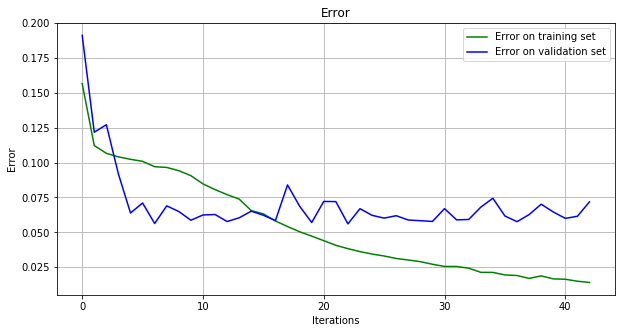

In [295]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title('Error')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Error on training set') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Error on validation set')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid(True)
plt.show()